# Using adversarial networks to extend brain computer interface decoding accuracy over time

## The problem -- the performance of a well-calibrated iBCI decoder degrades over time

Intracortical brain-computer interfaces (iBCIs) uses a "decoder" to translate the moment-to-moment neural activity into a signal for intended movements, so as to help restore lost motor functions for people with paralysis (Figure 1A). 

The instability in neural recordings is a major hurdle to the long-term stability of iBCIs. Let's imagine the following case. On day-0, a BCI decoder is well calibrated and learned by the user. As time goes, usually we will see substantial changes in acquired neural signals on day-k. Such changes would hurt the performance of the well-calibrated day-0 decoder a lot (see Figure 1B) so that the intent of the user cannot be accurately predicted any more.    

One way to solve this problem is to simply recalibrate the decoder with newly acquired data. Apparently, the normal use of the BCI system would be interrupted during recalibration, and it will take additional time and efforts for the user to learn the recalibrated decoder.

![fig1](./images/fig1.png)
*Figure 1 A) The decoder for intracortical brain-computer interfaces (iBCIs). B) A well-calibrated decoder could produce accurate estimations of the EMGs on day-0, but failed on day-k.*

## We propose to use adversarial networks to extend brain computer interface decoding accuracy over time

An ideal iBCI would accommodate the instabilities in neural recordings without supervision, thereby minimizing the need to periodically learn new decoders. But, how to do it? 

As mentioned above, it is mainly due to the changes of neural signals from day-0 to day-k that a well-calibrated day-0 decoder failed on day-k. If we apply some transformation on day-k neural signals to make them similar to day-0 neural signals, would the performance of the day-0 decoder be maintained on day-k? [Our preprint](https://www.biorxiv.org/content/10.1101/2022.08.26.504777v1) shows that this notion is feasible to extend BCI decoding accuracy over time. 

In our study, we use Adversarial Domain Adaptation Network (ADAN, Farshchiansadegh et al., 2019) to implement such transformation on day-k neural signals. The results we obtained showed that even ~3 months after decoder training the performance of the day-0 decoder can be maintained if using ADAN to **"align"** the full-dimentional neural signals. We call this process **"alignment"**, and use ADAN as the **"aligner"**. We also showed that ADAN alignment can be done on continuous recordings, which means, there is no need to align trials according to specific behavioral events.

This notebook will walk you through this approach using a dataset collected from a monkey who kept doing a motor task over 90 days.
![fig2](./images/exp_background.png)
*Figure 2 The isometric wrist center-out task*

## Datasets

The datasets are from a monkey (monkey J) doing an isometric wrist torque task. This task requires the monkey to control the cursor on the screen by exerting forces on a small box placed around one of the hands. The box was padded to comfortably constrain the monkey’s hand and minimize its movement within the box, and the forces were measured by a 6 DOF load cell (JR3 Inc., CA) aligned to the wrist joint. During the task, flexion/extension force moved the cursor right and left respectively, while force along the radial/ulnar deviation axis moved the cursor up and down. Each trial started with the appearance of a center target requiring the monkeys to hold for a random time (0.2 – 1.0 s), after which one of eight possible outer targets selected in a block-randomized fashion appeared, accompanied with an auditory go cue. The monkey was allowed to move the cursor to the target within 2.0 s and hold for 0.8 s to receive a liquid reward (Figure 2). For both decoding and alignment analyses, we only used the data within each single trial (from ‘trial start’ to ‘trial end’, Figure 2). **We did not do any temporal alignment with the trials, so the lengths of the trials were different from each other**. 

This dataset could be downloaded from Dryad. We are going to use [xds](https://github.com/limblab/xds) package to load the data. Please see another notebook to learn more about `xds`.

Two packages need to be downloaded and included in your `Python` path.
The first is `xds` for data loading, which could be downloaded via this [link](https://github.com/limblab/xds).
The second is `decoder_standard` for BCI decoder training. We will use functions `train_wiener_filter` and `test_wiener_filter` to train Wiener filter based BCI decoders. These codes could be download from [here](https://github.com/xuanma/decoder_standard).

### Load necessary packages and put the directories of `xds` and `decoder_standard` in the path

In [1]:
import fnmatch, os, sys
sys.path.append('C:/Users/fabio/Documents/GitKrakenHub/xds/xds_python/')
sys.path.append('C:/Users/fabio/Documents/GitKrakenHub/decoder_standard')

In [2]:
from IPython.display import clear_output
import numpy as np
from xds import lab_data
from dateutil.parser import parse
import pickle
from datetime import datetime

### Load data and do preprocessing

M1 activity was recorded using a Cerebus system (Blackrock Neurotech, Inc.). The signals on each channel were digitalized, bandpass filtered (250 ~ 5000 Hz) and converted to spike times based on threshold crossings. The threshold was set with respect to the root-mean square (RMS) activity on each channel and kept consistent across different recording days (-5.5 x RMS). The time stamp and a 1.6 ms snippet of each spike surrounding the time of threshold crossing were recorded. For all analyses here, we used multiunit threshold crossings on each channel instead of discriminating well isolated single units. We applied a Gaussian kernel (S.D. = 100 ms) to the spike counts in 50 ms, non-overlapping bins to obtain a smoothed estimate of firing rate as function of time for each channel.

One addtional preprocessing step for M1 spike firing rates is illustrated below. If no spike is detected on a channel (electrode) the recording system will skip it, therefore resulting in inconsistent number of channles on different days. To keep the number of M1 channels consistent across different recording days, we pad the empty channels on day-k (Figure 3A, E3 and E5 on day-k) with all zeros.

The EMG signals were differentially amplified, band-pass filtered (4-pole, 50 ~ 500 Hz) and sampled at 2000 Hz. The EMGs were subsequently digitally rectified and low-pass filtered (4-pole, 10 Hz, Butterworth) and subsampled to 20 Hz (Figure 3B). EMG channels with substantial noise were not included in the analyses, and data points of each channel were clipped to be no larger than the mean plus 6 times the S.D. of that channel. Within each recording session, we removed the baseline of each EMG channel by subtracting the 2nd percentile of the amplitudes and normalized each channel to the 90th percentile.

<img src="./images/preprocessing.png" style = "width: 800px" align="left"/>

*Figure 3 Preprocessing for M1 spike firing rates and EMGs. A) The zero-padding step for empty channels on day-k. B) From raw EMGs to EMG envolops*

All data files are stored under the directory of `./data`. Below we will scan the directory and list the names of the data files. The data files are named like **`monkey_date_number.mat`**

In [3]:
%load_ext autoreload
%autoreload 2

data_path = 'C:/Users/fabio/Documents/GitKrakenHub/monkey_analysis/Lab/data/IB/Jango_2015_isometric_wrist_task/'
mat_list = np.sort(fnmatch.filter(os.listdir(data_path), "*.mat")) # We sorted the files by name.
print(mat_list)

['Jango_20150730_001.mat' 'Jango_20151029_001.mat']


Here we will use the data recorded on **07/30/2015** as the day-0 data. Therefore, we need to load the file **`Jango_20150730_001.mat`** first. We named the variables associated with this file as **`day0_XXX`**. For day-k data, in this notebook we will use the data recorded on **10/29/2015**, so we will need to load **`Jango_20151029_001.mat`**. Likewise, we named the variables associated with day-k as **`dayk_XXX`**.

In [4]:
from utils import emg_preprocessing, spike_preprocessing

bin_size = 0.05 # As mentioned above, we use 50 ms bins to calculate the spike counts
smooth_size = 0.1 # As mentioned above, we use Gaussian kernels (S.D. = 100 ms) to smooth the binned spikes
N_elec = 96 # The monkey was implanted with a 96-channel Utah array

#============================================= Load day-0 data ==================================================================#
day0_data = lab_data(data_path, 'Jango_20150730_001.mat') # Load the data using the lab_data class in xds.py
day0_data.update_bin_data(bin_size)  # Bin the spikes with the specified bin_size
day0_data.smooth_binned_spikes(bin_size, 'gaussian', smooth_size) # Smooth the binned spike counts
day0_unit_names = day0_data.unit_names
#-------- Extract smoothed spike counts in trials without temporal alignment --------#
day0_spike = day0_data.get_trials_data_spike_counts('R', 'start_time', 0.0, 'end_time', 0)
day0_EMG_names = day0_data.EMG_names
#-------- Extract EMG envelops in trials without temporal alignment --------#
day0_EMG = day0_data.get_trials_data_EMG('R', 'start_time', 0.0, 'end_time', 0)
day0_EMG, day0_EMG_names = emg_preprocessing(day0_EMG, day0_EMG_names) # outlier removal and normalization

#============================================= Load day-k data ==================================================================#
dayk_data = lab_data(data_path, 'Jango_20151029_001.mat')
dayk_data.update_bin_data(bin_size)  
dayk_data.smooth_binned_spikes(bin_size, 'gaussian', smooth_size)
dayk_unit_names = dayk_data.unit_names
#-------- Extract smoothed spike counts in trials without temporal alignment --------#
dayk_spike = dayk_data.get_trials_data_spike_counts('R', 'start_time', 0.0, 'end_time', 0)
dayk_EMG_names = dayk_data.EMG_names
#-------- Extract EMG envelops in trials without temporal alignment --------#
dayk_EMG = dayk_data.get_trials_data_EMG('R', 'start_time', 0.0, 'end_time', 0)
dayk_EMG, dayk_EMG_names = emg_preprocessing(dayk_EMG, dayk_EMG_names)

#============================================= Pre-processing ==================================================================#
day0_spike, dayk_spike = spike_preprocessing(day0_unit_names, dayk_unit_names, day0_spike, dayk_spike) # zero-padding empty channels

#============================================= variable information ============================================================#
print('=============================================================')
print('Day-0 data contains %d trials.'%(len(day0_spike)))
print('The %dth trial on day-0 contains %d time steps.'%(46, day0_spike[46].shape[0]))
print('Cortical data on day-0 contains %d channels.'%(day0_spike[46].shape[1]))
print('EMG data on day-0 contains %d muscles.'%(day0_EMG[46].shape[1]))

Trials with nan timings have been removed!
The new bin size is 0.0500 s
The new bin size is 0.0500 s
Day-0 data contains 162 trials.
The 46th trial on day-0 contains 54 time steps.
Cortical data on day-0 contains 96 channels.
EMG data on day-0 contains 7 muscles.


Below is a list showing the names of the variables and meanings:
* `day0_data`: a `lab_data` object for storing and managing data recorded on day-0.
* `day0_unit_names`: unit names for day-0 M1 recordings. Since we **did not** do spike sorting, these names are actually the names for the electrodes.
* `day0_spike`: a list storing the smoothed spike counts obtained on day-0. Each item in the list is a `numpy` array with shape (number of time bins, number of channels/electrodes), corresonding to a trial.
* `day0_EMG`: a list storing the EMG envelops obtained on day-0. Each item in the list is a `numpy` array with shape (number of time bins, number of muscles), corresonding to a trial.
* `dayk_data`: a `lab_data` object for storing and managing data recorded on day-k.
* `dayk_unit_names`: unit names for day-k M1 recordings.
* `dayk_spike`: a list storing the smoothed spike counts obtained on day-k.
* `dayk_EMG`: a list storing the EMG envelops obtained on day-k.

### Selecting the first 160 trials for each day

To control the amount of training and testing data in an easier manner, we will only use the first 160 trials on each day for all the analyses below.

In [5]:
trial_num = 160
day0_spike_ = day0_spike[:trial_num]
day0_EMG_ = day0_EMG[:trial_num]
dayk_spike_ = dayk_spike[:trial_num]
dayk_EMG_ = dayk_EMG[:trial_num]

The meanings of the variables:
* `day0_spike_`: the first 160 trials of `day0_spike`.  
* `day0_EMG_`: the first 160 trials of `day0_EMG`.
* `dayk_spike_`: the first 160 trials of `dayk_spike`. 
* `dayk_EMG_`: the first 160 trials of `dayk_EMG`.

## Train ADAN day-0 model (4-fold cross validation)

Here we use a Wiener filter to predict the EMGs from M1 neural activity. The day-0 wiener filter for ADAN was built from a nonlinear latent space estimated from day-0 neural firing rates using an autoencoder (AE) originally described in (Farshchiansadegh et al., 2019). As in the original implementation, the AE consists of an input layer, five hidden layers and an output layer. The input and the output layers have C units, while the hidden layers (from input to output) have 64, 32, 10, 32 and 64 units, respectively. Hence, the AE compresses the C-dimensional neural firing rates into a 10-dimensional latent representation.

The units in the layer and the output layers as well as those in the latent layer have linear activation functions, while units in the remaining hidden layers have a nonlinear one (exponential linear unit, ELU). The AE is trained to minimize
the reconstruction error defined as the mean square error (MSE) between the input and the output data. When day-0 neural firing rates $\boldsymbol{X}$ are fed through the AE, the latent layer activity $\boldsymbol{l}$ and the corresponding reconstructions $\boldsymbol{\hat{X}}$ are obtained. The actual motor output recorded at day-0 ($\boldsymbol{Y}$) is then predicted using the 10-dimensional latent activity $\boldsymbol{l}$ through a long-short-term memory (LSTM, (Hochreiter & Schmidhuber, 1997)) network:

$$
\boldsymbol{\hat{Y}} = LSTM(\boldsymbol{l})
$$

where $\boldsymbol{\hat{Y}}$ is the predicted motor output. The LSTM is designed with one layer and a number of units that equals the number of recorded motor outputs. Note that this LSTM based decoder is only used for latent space discovery, not the later decoding stage that is used for performance evaluation. The AE and the LSTM are simultaneously trained by minimizing a loss function that accounts for both the MSE of the reconstruction of the firing rates ($\mathcal{L}(AE)$) and the MSE of the motor output predictions ($\mathcal{L}(LSTM)$):

$$
\mathcal{L}= \lambda\mathcal{L}(AE) + \mathcal{L}(LSTM) = \frac{1}{M} \sum_{i=1}^{M}(\lambda \|\hat{X}-X\|^2 + \|\hat{Y}-Y\|^2)
$$

where M is the total number of training samples. The weighting factor $\lambda$ equalizes the contribution of the two terms so that the learning algorithm does not prioritize one over the other. For each training epoch, $\lambda$ is updated as the ratio between the values of $\mathcal{L}(AE)$ and $\mathcal{L}(LSTM)$ at the end of the preceding epoch. 




<img src="./images/adan_day0.png" style = "width: 800px" align="center"/>

*Figure 4 ADAN day-0 model consisting of a neural autoencoder and an LSTM-based BCI decoder*

### Specify Hyper-parameters and define ADAN day-0 network

There are a few hyper-parameters for the training of the ADAN day-0 model. We organized them into a `Python` dictionary:
  
* training_params:
  - spike_dim: the number of recorded electrodes
  - emg_dim: the number of recorded motor outputs (EMGs in this example)
  - latent_dim: the dimensionality of the AE latent space
  - lstm_units: the nuber of units of the ADAN LSTM decoder
  - lstm_layers: the number of layers of the ADAN LSTM decoder
  - n_lags: number indicating the number of time lags for the LSTM decoder
  - epochs: the number of training epochs
  - batch_size: the size of training batches
  - lr: the learning rate for the ADAN network
  - cv_folds: the number of folds for k-fold cross validation

In [6]:
training_params = {}
training_params['spike_dim'] = day0_spike[46].shape[1]
training_params['emg_dim'] = day0_EMG[46].shape[1]
training_params['latent_dim'] = 10
training_params['lstm_units'] = day0_EMG[46].shape[1]
training_params['lstm_layers'] = 1
training_params['n_lags'] = 4
training_params['epochs'] = 200
training_params['batch_size'] = 64
training_params['lr'] = 0.001
training_params['cv_folds'] = 4

In [7]:
def autoencoder(input_, training_params, reuse=False):
    n_units = [64, 32, training_params['latent_dim']]
    with tf.variable_scope('autoencoder', reuse=reuse):
        h1 = tf.layers.dense(input_, units=n_units[0], activation=tf.nn.elu)
        h2 = tf.layers.dense(h1, units=n_units[1], activation=tf.nn.elu)
        latent = tf.layers.dense(h2, units=n_units[2], activation=None)
        h3 = tf.layers.dense(latent, units=n_units[1], activation=tf.nn.elu)
        h4 = tf.layers.dense(h3, units=n_units[0], activation=tf.nn.elu)
        logits = tf.layers.dense(h4, units=training_params['spike_dim'], activation=None)
        return latent, logits


def emg_decoder(latent, training_params, reuse=False):
    with tf.variable_scope('emg_decoder', reuse=reuse):
        latent = tf.reshape(latent, [-1, training_params['n_lags'], training_params['latent_dim']])
        layers = [tf.nn.rnn_cell.LSTMCell(num_units=training_params['lstm_units'], activation=tf.nn.elu)
                  for layer in range(training_params['lstm_layers'])]
        multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
        outputs, states = tf.nn.dynamic_rnn(multi_layer_cell,latent, dtype=tf.float32)
        emg_hat = tf.layers.dense(outputs, units=training_params['emg_dim'], activation=None)
        emg_hat = tf.reshape(emg_hat,[-1,training_params['emg_dim']])
        return emg_hat
    
    
def get_batches(x,batch_size):
    n_batches = len(x)//(batch_size)
    x = x[:n_batches*batch_size:]
    for n in range(0, x.shape[0],batch_size):
        x_batch = x[n:n+(batch_size)]
        yield x_batch

### Define ADAN day-0 model

In [8]:
import tensorflow as tf

tf.reset_default_graph()
tf.set_random_seed(seed=42)

spike = tf.placeholder(tf.float32, (None,training_params['spike_dim']), name='spike')
emg = tf.placeholder(tf.float32, (None,training_params['emg_dim']), name='emg')
gamma = tf.placeholder(tf.float32)


latent,logits = autoencoder(spike, training_params)
emg_hat = emg_decoder(latent, training_params)
emg_hat = tf.identity(emg_hat, name='emg_hat')

# ---- Decoder Losses and Optimizers ---- #
ae_loss = tf.reduce_mean(tf.square(logits - spike))
emg_loss = tf.reduce_mean(tf.square(emg_hat - emg))
total_loss = gamma*ae_loss + emg_loss
optimizer = tf.train.AdamOptimizer(learning_rate=training_params['lr']).minimize(total_loss)

C:\Users\fabio\Anaconda3\envs\tf1.0\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fabio\Anaconda3\envs\tf1.0\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fabio\Anaconda3\envs\tf1.0\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fabio\Anaconda3\envs\tf1.0\lib\site-packages\tensorflow\python\f





Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



The simultaneous training of the AE and the LSTM allows extracting a low-dimensional space of neural activity constrained to include features related to movement intent. Such latent signals are then used to train the Wiener filter used as the fixed day-0 decoder for this study. At each epoch of training, the current latent signal was used to obtain a linear prediction of the actual motor output. We used 400 epochs of training and ultimately selected the parameters of the wiener filter at the epoch that had the best performance (in the R2 sense) on the held-out test set.. This type of decoder have been widely used in the past (Cherian, Krucoff, and Miller 2011; Naufel et al. 2019). The filter uses linear regression to predict the EMGs at time t with the given inputs stretching from present to T time bins in the past. We set T = 4 (200 ms) for the decoders here.

Specifically, a Wiener filter can be written in this form:
$$
\boldsymbol{y} (t)=\sum_{\tau=0}^{T-1}\boldsymbol{\beta}(\tau)\boldsymbol{x}(t-\tau)
$$

where $\boldsymbol{y}(t)$ is a q-dimensional vector ($q$ varied with the number of recorded EMGs) representing the EMGs to be predicted at time $t$, while $\boldsymbol{x}(t)$ is a $p$-dimensional vector for the inputs to the Wiener filter at time $t$ ($p=96$ in this case, which is the number of the electrodes in the cortical array), and $\boldsymbol{\beta}(\tau)$ is a $q\times p$ matrix corresponding to the filter parameters for time step $\tau$.

Of course, we can also write the equation for the Wiener filter in a matrix form:
$$
\boldsymbol{Y} = \boldsymbol{X}\boldsymbol{B}
$$

where $\boldsymbol{Y}$ is a $M\times q$ matrix for the EMGs to be predicted with $M$ being the number of samples, $\boldsymbol{X}$ is a $M\times (T\times p)$ matrix, and $\boldsymbol{B}$ is a $(T \times p)\times q$ matrix for the regression coefficients to be estimated.

A commonly used technique to prevent overfitting when estimating $\boldsymbol{B}$ is to add an *L2* regularization term in the cost function of the regression. Here we will take advantage of this technique. In function `train_wiener_filter` there is an option `l2` to indicate if the *L2* regularization is needed. `l2 = True` for *YES*, while `l2 = False` for *NO*.

<img src="./images/adan_wiener.png" style = "width: 800px" align="center"/>

*Figure 5 A Wiener filter based BCI decoder using ADAN AE latent space input*

Before the actual decoder training, we need to format the input data to fit the requirements of the Wiener filter. Below is a toy example, where $T=4, p=4, q=2$, and 10 time steps are shown.

<img src="./images/wiener_filter_format.png" style = "width: 800px" align="center"/>
<img src="./images/wiener_filter_format_2.png" style = "width: 800px" align="center"/>

*Figure 6 Format input data to fit the requirement of the Wiener filter*

In this case, X will have $4\times4$ columns, and Y still has 2 columns. Since the first 3 time steps would be a blind zone for the Wiener filter, we should get $10-4+1 = 7$ training samples from the 10 time steps. In order to use the data from multiple trials as the training data, we will need to do this reshaping for each trial, and then concatenate them together. The function `format_data_from_trials` is used to do this job.

To evaluate the goodness of fit for the EMGs on a specific muscle, we could use the coefficient of determination, namely, the $R^{2}$, which is defined below:

$$
R^{2}(y, \hat{y}) = 1-\frac{\sum_{i=1}^{N}(\hat{y}_{i}-y_{i})^2}{\sum_{i=1}^{N}(y_{i}-\bar{y}_{i})^2}
$$

Here $N$ represents the total number of samples used to compute the $R^2$ value, and both $y$ and $\hat{y}$ are for one single muscle. If there are 11 muscles, then we will have 11 $R^2$ values for all the muscles.

What if we want to use a single number to quantify the prediction accuracy of the decoder? To do this, we can use a multi-variate $R^2$ defined as below:

$$
mR^{2}(y, \hat{y}) = 1-\frac{\sum_{m=1}^{M}\sum_{i=1}^{N}(\hat{y}_{i,m}-y_{i,m})^2}{\sum_{m=1}^{M}\sum_{i=1}^{N}(y_{i,m}-\bar{y}_{i,m})^2}
$$

Here M represents the number of muscles. 

Regarding this metric, please read our [our preprint](https://www.biorxiv.org/content/10.1101/2022.08.26.504777v1) for more information.

Finally, we will pick the best decoder through the 4-fold CV, and save it for the tests below. This could be implemented by the function `kFold` in *scikit-learn* package.

## Train (or resume) Day-0 decoder, using Wiener filter as the decoder

In [9]:
from wiener_filter import format_data_from_trials, train_wiener_filter, test_wiener_filter
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from utils import list_to_nparray

# ---- Create debug folders ---- #
for cv in range(training_params['cv_folds']):
    if not os.path.exists(os.path.join(os.getcwd(), 'decoders/adan/' + str(cv))):
        os.makedirs(os.path.join(os.getcwd(), 'decoders/adan/' + str(cv)))
    if not os.path.exists(os.path.join(os.getcwd(), 'results/' + str(cv))):
        os.makedirs(os.path.join(os.getcwd(), 'results/' + str(cv)))

resume_decoder = True  # False if ADAN day-0 model has not been trained yet
n_lags = 4 # the number of time lags in Wiener filter
cv_folds = training_params['cv_folds']
kf = KFold(n_splits=cv_folds, shuffle=False)

decoder_list = [] # for decoder saving
mr2_list = [[] for cv in range(cv_folds)] # for multi-variate r2 saving
r2_list = [[] for cv in range(cv_folds)] # for single-channel r2 saving

for cv, (train_idx, test_idx) in enumerate(kf.split(day0_spike_)):
    #------ select training and test trials from the specified fold ------#
    x_train = list_to_nparray([day0_spike_[i] for i in train_idx])
    y_train = list_to_nparray([day0_EMG_[i] for i in train_idx])
    x_test = list_to_nparray([day0_spike_[i] for i in test_idx])
    y_test = list_to_nparray([day0_EMG_[i] for i in test_idx])
    
     #-- ADAN requires an np.array of concateated trials whose length is a multiple of the chosen batch size--#
    idx_tr = int(len(x_train) // training_params['n_lags'] * training_params['n_lags'])
    x_train = x_train[:idx_tr]
    y_train = y_train[:idx_tr]
    idx_te = int(len(x_test) // training_params['n_lags'] * training_params['n_lags'])
    x_test = x_test[:idx_te]
    y_test = y_test[:idx_te]
    
    #------ start training of ADAN day-0 model ------#
    if not resume_decoder:
        best_mr2 = -1e10
        n_batches = len(x_train)//training_params['batch_size']
        gamma_ = np.float32(1.)
        saver = tf.train.Saver(max_to_keep=1)
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            init.run()

            for epoch in range(training_params['epochs']):
                # ---- Get batches for neural and emg data ---- #
                    spike_gen_obj = get_batches(x_train,training_params['batch_size'])
                    emg_gen_obj = get_batches(y_train,training_params['batch_size'])

                    # ---- Run batch GD ---- #
                    for ii in range(n_batches):
                        spike_batch = next(spike_gen_obj)
                        emg_batch = next(emg_gen_obj)
                        sys.stdout.flush()
                        sess.run(optimizer,feed_dict={spike: spike_batch, emg: emg_batch, gamma: gamma_})

                    # ---- Compute AE and LSTM loss and apply forward pass---- #
                    ae_loss_ = ae_loss.eval(feed_dict={spike: x_train, emg: y_train, gamma: gamma_})
                    emg_loss_ = emg_loss.eval(feed_dict={spike: x_train, emg: y_train, gamma: gamma_})
                    gamma_ = emg_loss_/ae_loss_

                    pred_x_train, pred_x_test = [logits.eval(feed_dict={spike: x_train}),
                                                logits.eval(feed_dict={spike: x_test})]
                    pred_y_train, pred_y_test = [emg_hat.eval(feed_dict={spike: x_train, emg: y_train}),
                                                emg_hat.eval(feed_dict={spike: x_test, emg: y_test})]

                    # ---- Train and test wiener filter based decoder using AE latent signals---- #
                    x_train_lat = latent.eval(feed_dict={spike: x_train})
                    x_train_lat_, y_train_ = format_data_from_trials(x_train_lat, y_train, training_params['n_lags'])
                    H = train_wiener_filter(x_train_lat_, y_train_, l2=1, print_output=False)

                    x_test_lat = latent.eval(feed_dict={spike: x_test})
                    x_test_lat_, y_test_ = format_data_from_trials(x_test_lat, y_test, training_params['n_lags'])
                    pred_y_train_ = test_wiener_filter(x_train_lat_, H)
                    pred_y_test_ = test_wiener_filter(x_test_lat_, H)

                    mr2 = r2_score(y_test_, pred_y_test_, multioutput='variance_weighted')

                    # ---- Report results for current epoch and save model---- #
                    if mr2 > best_mr2:
                        best_mr2 = mr2
                        mr2_list[cv] = mr2
                        r2_list[cv] = r2_score(y_test_, pred_y_test_, multioutput='raw_values')
                        saver.save(sess, './decoders/adan/' + str(cv) + '/decoder')
                        np.save('./decoders/adan/' + str(cv) + '/Day-0 decoder', H)

                    if (epoch % 10 == 0) or (epoch == training_params['epochs']-1):
                        print("CV fold:", cv,"\tEpoch:", epoch, "\tAE_loss:",ae_loss_, "\tLSTM EMG_loss:",emg_loss_)
                        print("AE Train %R2:", r2_score(x_train, pred_x_train, multioutput='variance_weighted'),
                              "\AE Test %R2:", r2_score(x_test, pred_x_test, multioutput='variance_weighted'))
                        print("LSTM EMG Train %R2:", r2_score(y_train, pred_y_train, multioutput='variance_weighted'),
                              "\LSTM EMG Test %R2:", r2_score(y_test, pred_y_test, multioutput='variance_weighted'))
                        print("Wiener: EMG Train %R2:", r2_score(y_train_, pred_y_train_, multioutput='variance_weighted'), 
                              "\EMG Test %R2:", r2_score(y_test_, pred_y_test_, multioutput='variance_weighted'))
            print("End of training fold ", str(cv), "\n")
    
    #------ resume an already trained ADAN day-0 model ------#
    else:
        H = np.load('./decoders/adan/' + str(cv) + '/Day-0 decoder.npy')
        tf.reset_default_graph()
        g = tf.train.import_meta_graph('./decoders/adan/' + str(cv) + '/decoder.meta')
        graph = tf.get_default_graph()
        spike = graph.get_tensor_by_name("spike:0")
        
        # ---- Set parameters of AE as those saved after training---- #
        latent, logits = autoencoder(spike, training_params)
        t_vars = tf.trainable_variables()
        a_vars = [var.name for var in t_vars if var.name.startswith('autoencoder')]
        for i, name in enumerate(a_vars):
            # calling autoencoder model makes other 12 layers appearing, consider only first 12
            if i < 12:
                tf.train.init_from_checkpoint('./decoders/adan/' + str(cv) + '/', {name[:-2]: a_vars[i][:-2]})
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            init.run()
            g.restore(sess, tf.train.latest_checkpoint('./decoders/adan/' + str(cv) + '/'))
            
            # ---- Forward pass of day-0 decoder ---- #
            x_test_lat = latent.eval(feed_dict={spike: x_test})
            x_test_lat_, y_test_ = format_data_from_trials(x_test_lat, y_test, training_params['n_lags'])
            pred_y_test_ = test_wiener_filter(x_test_lat_, H)
            mr2_list[cv] = r2_score(y_test_, pred_y_test_, multioutput='variance_weighted')
            r2_list[cv] = r2_score(y_test_, pred_y_test_, multioutput='raw_values')

print('The multi-variate r2 values for all the folds are:')
print(mr2_list)
best_fold = np.argmax(mr2_list)    




Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./decoders/adan/0/decoder


INFO:tensorflow:Restoring parameters from ./decoders/adan/1/decoder


INFO:tensorflow:Restoring parameters from ./decoders/adan/2/decoder
INFO:tensorflow:Restoring parameters from ./decoders/adan/3/decoder
The multi-variate r2 values for all the folds are:
[0.7209513155910803, 0.7541318758105107, 0.7475076185276464, 0.6903486795736482]


Important variables:
* pred_y_test: the predicted EMG in the testing trials, a numpy array containing concatenated trials.
* mr2: the multi-variate $R^2$ between the actual and predicted EMGs in the testing set.

Important functions:
* `[x_, y_] = format_data_from_trials(x, y, n_lags)`:
  - x: a list, where each element is a numpy array containing the spike firing rates for a trial
  - y: a list, where each element is a numpy array containing the EMGs for a trial
  - n_lags: a number indicating the number of time lags for Wiener filter
  
  returns:
  - x_: x after formatting
  - y_: y after formatting

* `H = train_wiener_filter(x, y, l2 = 1)`:
  - x: a numpy array, formatted spike firing rates for concatenated trials
  - y: a numpy array, formatted EMGs for concatenated trials
  - l2: bool, a label to indicate if L2 regularization term is needed
  
  returns:
  - H: the decoder coefficients matrix
  
* `pred_y = test_wiener_filter(x, H)`
  - x: a numpy array, formatted spike firing rates for concatenated trials
  - H: the decoder coefficients matrix
  
  returns:
  - pred_y: a numpy array, EMGs predicted by the decoder, in concatenated trials

## Define the blocks for the ADAN based aligner

Now we are going to build the ADAN based aligner described in [Our preprint](https://www.biorxiv.org/content/10.1101/2022.08.26.504777v1). We will train it with a certain number of trials. We will test the performance of the day-0 decoder after aligning day-k data using the ADAN based aligner. We will use `tensorflow 1.0` for all the implementations. Since our approach is quite effecient, a CPU is already good enough for the training, while a GPU may not be used.

First let's define the architectures of the generator and the discriminator networks.

Here all the networks are simple feedforward neural networks with a single hidden layer.

### The definition of the generator network

The ADAN generator is a shallow feedforward neural networks with one hidden layer. It takes N channels of spike firing rates as the input, and output N channels of aligned spike firing rates. It acts as a distribution aligment module.

<img src="./images/adan_generator_network.png" style = "width: 400px" align="left"/>

In [10]:
def generator(input_, training_params, reuse=False):
    with tf.variable_scope('generator',initializer=tf.initializers.identity(),reuse=reuse):
        h1 = tf.layers.dense(input_,training_params['spike_dim'],activation=tf.nn.elu)
        output = tf.layers.dense(h1,training_params['spike_dim'],activation=None)
    return output

### The definition of the discriminator network

The ADAN discriminator is an autoencoder and has the same architecture as that used to find the nonlinear latent space on day-0.

<img src="./images/adan_discriminator_network.png" style = "width: 700px" align="left"/>

In [11]:
def discriminator(input_, training_params, reuse=False):
    n_units = [64, 32, training_params['latent_dim']]
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        noise = tf.random_normal(tf.shape(input_), dtype=tf.float32)
        input_ = input_+noise
        h1 = tf.layers.dense(input_, units=n_units[0], activation=tf.nn.elu)
        h2 = tf.layers.dense(h1, units=n_units[1], activation=tf.nn.elu)
        latent = tf.layers.dense(h2, units=n_units[2], activation=None)
        h3 = tf.layers.dense(latent, units=n_units[1], activation=tf.nn.elu)
        h4 = tf.layers.dense(h3, units=n_units[0], activation=tf.nn.elu)
        logits = tf.layers.dense(h4, units=training_params['spike_dim'], activation=None)
        return latent, logits

## Train and test an ADAN based aligner

The generator (G) and discriminator (D) form a pair of adversarial networks: generator maps data from the day-k domain to the day-0 domain, while discriminator aims to distinguish between the day-0 samples and the output of generator, see the figure below.

During training of the aligner, the generator is fed with day-k neural firing rates and applies a nonlinear transform over these data to match them to the day-0 neuron response distributions. The output of the generator, and the true day-0 neural firing rates are then passed to the discriminator, which passes both inputs through the autoencoder: namely, it projects each signal into the latent space and then reconstructs it. The distributions of the residuals between the autoencoder inputs and the reconstructions are computed for both the generator output and the true day-0 data, and a lower bound to the Wasserstein distance () is used to measure the dissimilarity between the two distributions. The goal of adversarial learning is to find a discriminator that maximizes the dissimilarity between responses of D to true day-0 firing rates and to outputs of G, while also finding a generator G that minimizes the dissimilarity between true day-0 firing rates and the outputs of G; this objective is called the adversarial loss. When the training is completed, G will have been trained to “align” the neural firing rates on day-k with those on day-0. For a full description of the ADAN architecture and its training strategy, please refer to [our preprint](https://www.biorxiv.org/content/10.1101/2022.08.26.504777v1).

![cycle_gan_structure](./images/adan_structure.png)

### Define ADAN day-k model graph and hyperparameters

* training_params:
  - epochs: the number of training epochs
  - batch_size: the size of training batches. Smaller batch sizes are recommended for trainin stability
  - D_lr: the learning rate for the discriminator network
  - G_lr: the learning rate for the generator network

In [12]:
#============================= These parameters are for the training process =============================
training_params['epochs'] = 200
training_params['batch_size'] = 8
training_params['D_lr'] = 0.00005
training_params['G_lr'] = 0.0001

# ---- ADAN Graph ---- #
tf.reset_default_graph()
tf.set_random_seed(seed=42)
g = tf.train.import_meta_graph('./decoders/adan/' + str(best_fold) + '/decoder.meta')
graph = tf.get_default_graph()
spike = graph.get_tensor_by_name("spike:0")

# set parameters of AE as those saved after training
latent, logits = autoencoder(spike, training_params)
t_vars = tf.trainable_variables()
a_vars = [var.name for var in t_vars if var.name.startswith('autoencoder')]

# set parameters of AE as those saved after training
# Initialize all variables in `new_scope_1` from `old_scope_1`.
# init_from_checkpoint('/tmp/model.ckpt', {'old_scope_1/': 'new_scope_1/'})
for i, name in enumerate(a_vars):
    if i < 12:
        tf.train.init_from_checkpoint('./decoders/adan/' + str(best_fold) + '/', {name[:-2]: a_vars[i][:-2]})

input_day0 = tf.placeholder(tf.float32, (None, training_params['spike_dim']), name='input_day0')
input_dayk = tf.placeholder(tf.float32, (None, training_params['spike_dim']), name='input_dayk')

input_dayk_aligned = generator(input_dayk, training_params)
latent_day0,logits_day0 = discriminator(input_day0, training_params)
latent_dayk,logits_dayk = discriminator(input_dayk_aligned, training_params)

# ---- ADAN Losses and Optimizers ---- #
d_loss_0 = tf.reduce_mean(tf.abs(logits_day0-input_day0))
d_loss_k = tf.reduce_mean(tf.abs(logits_dayk-input_dayk_aligned))
d_loss = d_loss_0 - d_loss_k
g_loss = d_loss_k

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_opt = tf.train.AdamOptimizer(learning_rate=training_params['D_lr']).minimize(d_loss, var_list=d_vars)
g_opt = tf.train.AdamOptimizer(learning_rate=training_params['G_lr']).minimize(g_loss, var_list=g_vars)

# set parameters of discriminator as the AE ones saved after training
for i, name in enumerate(a_vars):
    if i < 12:
        tf.train.init_from_checkpoint('./decoders/adan/' + str(best_fold) + '/', {name[:-2]: d_vars[i]})

### Write a function to train an ADAN based aligner

In [13]:
def train_adan_aligner(x1, x2, y2, training_params, decoder, best_fold, n_lags, logs = True):
    """
    x1: M1 spike firing rates on day-0. A list, where each item is a numpy array containing the neural data of one trial
    
    x2: M1 spike firing rates on day-k. A list, where each item is a numpy array containing the neural data of one trial
        x2 will be divided into two portions (ratio 3:1), where the first portion will be used to train the aligner, and 
        the second portion will be used as the validation set.
    
    y2: EMGs on day-k. A list, where each item is a numpy array containing the EMGs of one trial. Only a portion of y2
        (those corresponding to the trials used as the validation set) will be used.
    
    training_parameters: the hyper-parameters controlling the training process, a dictionary.
    
    decoder: the day-0 decoder to be tested on the validation set, an array.
    
    best_fold: the test fold that contains the best day-0 ADAN model, a number.
    
    n_lags: the number of time lags of the decoder, a number.
    
    logs: to indicate if training logs is needed to be recorded as a .pkl file, a bool.
    
    return: a trained "aligner" (generator) for day-k use (TODO)
    """
    #============================================= Specifying hyper-parameters =============================================
    epochs = training_params['epochs']
    batch_size = training_params['batch_size']
    D_lr = training_params['D_lr']
    G_lr = training_params['G_lr']
    
    #=============================== Split x2 into the actual training set and the validation set ==============================
    #----------- x2_train will be used in ADAN training -------------
    x2_train = x2[:int(len(x2)*0.75)] # training set
    
    #------- x2_valid and y2_valid will be isolated from training, and used to test the performance of the aligner every 10 trials
    x2_valid, y2_valid = x2[int(len(x2)*0.75):], y2[int(len(x2)*0.75):] # validation set
    
    #===================================  ADAN requires data as numpy array ============================================== 
    x1, x2_train = list_to_nparray(x1), list_to_nparray(x2_train)
    x2_valid, y2_valid = list_to_nparray(x2_valid), list_to_nparray(y2_valid)
        
    #============================================ Training logs =========================================================
    train_log = {'epoch':[], 'batch_idx': [],
                 'loss D':[], 'loss G':[],
                 'decoder r2 wiener': []}
    
    #============================================ Preparing to train ========================================================

    mr2_all_list = []
    
    saver = tf.train.Saver(max_to_keep=1)
    n_batches = min(len(x1), len(x2_train))//(batch_size)
    best_mr2 = -1e10

    # ---- Push AE and discriminator initializers ---- #
    init = tf.global_variables_initializer()

    #================================================== The training loop ====================================================
    with tf.Session() as sess:
        init.run()
        g.restore(sess, tf.train.latest_checkpoint('./decoders/adan/' + str(best_fold) + '/'))
        
        for epoch in range(epochs):
            # ---- Get batches for neural and emg data ---- #
            spike_0_gen_obj = get_batches(x1, batch_size)
            spike_k_gen_obj = get_batches(x2_train, batch_size)
                
            # ---- Run batch GD ---- #
            for batch_idx in range(n_batches):
                spike_0_batch = next(spike_0_gen_obj)
                spike_k_batch = next(spike_k_gen_obj)
                sys.stdout.flush()
                _,g_loss_ = sess.run([g_opt, g_loss],
                                     feed_dict={input_day0: spike_0_batch, input_dayk: spike_k_batch})
                _,d_loss_0_,d_loss_k_ = sess.run([d_opt, d_loss_0, d_loss_k],
                                                 feed_dict={input_day0: spike_0_batch, input_dayk: spike_k_batch})
                
                #====================================== save the training logs ========================================
                if logs == True:
                    train_log['epoch'].append(epoch)
                    train_log['batch_idx'].append(batch_idx)
                    train_log['loss D'].append(d_loss_k_)
                    train_log['loss G'].append(g_loss_)
                
            # -- Apply forward pass to obtain aligned day-k firing rates and test day-0 decoder on the validation set---- #
            x2_valid_lat = latent.eval(feed_dict={spike: x2_valid})
            x2_valid_lat_, y2_valid_ = format_data_from_trials(x2_valid_lat, y2_valid, n_lags)
            pred_y2_valid_nonalign_ = test_wiener_filter(x2_valid_lat_, decoder)
                
            x2_valid_aligned = input_dayk_aligned.eval(feed_dict={input_dayk: x2_valid})
            x2_valid_aligned_lat = latent.eval(feed_dict={spike: x2_valid_aligned})
            x2_valid_aligned_lat_, y2_valid_ = format_data_from_trials(x2_valid_aligned_lat, y2_valid, n_lags)
            pred_y2_valid_ = test_wiener_filter(x2_valid_aligned_lat_, decoder)

            # ---- Report results for current epoch and save model---- #
            mr2 = r2_score(y2_valid_, pred_y2_valid_, multioutput='variance_weighted')
            
            if mr2 > best_mr2:
                best_mr2 = mr2
                saver.save(sess, './decoders/adan/adan')

            #--------- Compute the multi-variate R2 between pred_y2_valid (predicted EMGs) and y2_valid (real EMGs) ----------
            mr2 = r2_score(y2_valid_, pred_y2_valid_, multioutput='variance_weighted')
            if (epoch + 1)%50 == 0:
                print('On the %dth epoch, the R\u00b2 on the validation set is %.2f'%(epoch+1, mr2))
            
            if (epoch % 10 == 0) or (epoch == epochs-1):
                    print("Epoch:", epoch, " Discriminator loss_day_0:", d_loss_0_, 
                          "\Discriminator loss_day_k:", d_loss_k_)
                    print("EMG non-aligned R2:", r2_score(y2_valid_, pred_y2_valid_nonalign_, multioutput='variance_weighted'),
                          "\tEMG aligned R2:", r2_score(y2_valid_, pred_y2_valid_, multioutput='variance_weighted'))
                    
            #------- Save the corresponding performance on the validation set ---------
            mr2_all_list.append(mr2)
            

    IDX = np.argmax(mr2_all_list) 
    print('The aligner has been well trained on the %dth epoch'%(IDX*10))
    train_log['decoder r2 wiener'] = mr2_all_list
    #============================================ save the training log =================================================
    if logs == True:
        dt_string = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
        with open('./train_logs/train_log_' + dt_string + '.pkl', 'wb') as fp:
            pickle.dump(train_log, fp)        

In [14]:
def test_adan_aligner(dayk_data, training_params):
    """
    net: the trained aligner
    dayk_data: the data that needs to be processed by the trained aligner
    """
    
    # ==== First, align day k neural data with ADAN generator ==== #
    dayk_aligned = []
    dayk_aligned_lat = []
    
    # ---- Restore trained ADAN model ---- #
    tf.reset_default_graph()
    g = tf.train.import_meta_graph('./decoders/adan/adan.meta')
    graph = tf.get_default_graph()
    input_dayk = graph.get_tensor_by_name("input_dayk:0")
    input_dayk_aligned = generator(input_dayk, training_params)

    # ---- Set parameters of generator as those saved after training ---- #
    t_vars = tf.trainable_variables()
    g_vars = [var.name for var in t_vars if var.name.startswith('generator')]
    for i, name in enumerate(g_vars):
        # having called generator model multiple times makes other 12 layers appearing in t_vars, consider only first 4
        if i < 4:
            tf.train.init_from_checkpoint('./decoders/adan/' , {name[:-2]: g_vars[i][:-2]})
    init = tf.global_variables_initializer()

    #------ Use the trained aligner to process the dayk_data ------#
    with tf.Session() as sess:
        init.run()
        g.restore(sess, tf.train.latest_checkpoint('./decoders/adan/'))
        for trial, val_trial in enumerate(dayk_data):
            dayk_aligned.append(input_dayk_aligned.eval(feed_dict={input_dayk: val_trial}))
                  
                  
    # ==== Then, use day-0 ADAN model to obtain aligned latent space to feed to fixed wiener decoder ==== #
    tf.reset_default_graph()
    g = tf.train.import_meta_graph('./decoders/adan/' + str(best_fold) + '/decoder.meta')
    graph = tf.get_default_graph()
    spike = graph.get_tensor_by_name("spike:0")
    latent, logits = autoencoder(spike, training_params)

    # ---- Set parameters of AE as those saved after training  ----#
    a_vars = [var.name for var in t_vars if var.name.startswith('autoencoder')]
    for i, name in enumerate(a_vars):
        # calling autoencoder model makes other 12 layers appearing, consider only first 12
        if i < 12:
            tf.train.init_from_checkpoint('./decoders/adan/' + str(best_fold) + '/', {name[:-2]: a_vars[i][:-2]})
    init = tf.global_variables_initializer()

    #------ Use the trained day-0 AE to process the aligned dayk_data ------#
    with tf.Session() as sess:
        init.run()
        g.restore(sess, tf.train.latest_checkpoint('./decoders/adan/' + str(best_fold) + '/'))
        # Aligned neural manifold
        for trial, val_trial in enumerate(dayk_aligned):
            dayk_aligned_lat.append(latent.eval(feed_dict={spike: val_trial}))

    
    #------ Return the aligned day-k data --------#
    return dayk_aligned, dayk_aligned_lat

### Train an ADAN based aligner using the function defined above

The figure below describes how we split the day-0 and day-k datasets for training and testing. Since ADAN tries to transform day-k data into a form resembling day-0 data, we will need both `day0_spike_` and `dayk_spike_` for the aligner training. We have found that the requirement for the amount of `day0_spike_` is not tight, so we include the first 50% of trials of `day0_spike_` in the training set (blue). We then split the `dayk_spike_` in to two portions, where the 75% of trials are for training, and 25% of trials are for testing (pink). Among the training trials, we further isolate 25% of trials to utilize as the validation set (green). The split of the validation set is implemented in the `train_adan_aligner` function.

<img src="./images/data_split.png" style = "width: 500px" align="center"/>

In [15]:
#================================ Load the trained day-0 decoder ========================================
day0_decoder = np.load('./decoders/adan/' + str(best_fold) + '/Day-0 decoder.npy')
#======================================== Train the aligner ===============================================
"""
Note for each dataset there are 160 trials. 50% corresponds to 80 trials and 75% corresponds to 120 trials.
The split of the validation set is implemented in the `train_adan_aligner` function.
"""
train_adan_aligner(day0_spike_[:80], dayk_spike_[:120], dayk_EMG_[:120],
                   training_params, day0_decoder, best_fold, n_lags, True)

'\nNote for each dataset there are 160 trials. 50% corresponds to 80 trials and 75% corresponds to 120 trials.\nThe split of the validation set is implemented in the `train_adan_aligner` function.\n'

### Test the trained aligner

As mentioned above, we are going to use the last 25% of trials (trials 120 ~ 160) of day-k data for the testing. First, we will need to use the trained aligner stored in the variable `aligner` to process `dayk_spike_`. The processed data are stored in `dayk_spike_aligned`.

We then load the trained day-0 decoder as shown above, then feed the decoder with `dayk_spike_aligned` (need to be formatted first). The outputs are saved in `pred_dayk_EMG_test_`. 

In [17]:
# ======================== Use function `test_adan_aligner` to process the day-k data =========================#
dayk_spike_aligned, dayk_spike_lat_aligned = test_adan_aligner(dayk_spike_[120:], training_params)

# ======================== Load the day-0 decoder, and feed it with the processed day-k data =======================#
day0_decoder = np.load('./decoders/adan/' + str(best_fold) + '/Day-0 decoder.npy')
dayk_spike_lat_aligned_, dayk_EMG_test_ = format_data_from_trials(dayk_spike_lat_aligned, dayk_EMG_[120:], n_lags)
pred_dayk_EMG_test_ = test_wiener_filter(dayk_spike_lat_aligned_, day0_decoder)

# ======================== Compute the multi-variate r2 between the predictions and the real EMGs =====================#
mr2 = r2_score(dayk_EMG_test_, pred_dayk_EMG_test_, multioutput='variance_weighted')
mr2 = format(mr2, '.2f')
print('The day-0 decoder achieved a multi-variate R\u00b2 of %s on day-k after the process of ADAN'%(mr2))

# ======================== The r2 for individual muscles (for the plotting in the next cell) =========================#
r2 = r2_score(dayk_EMG_test_, pred_dayk_EMG_test_, multioutput='raw_values')

INFO:tensorflow:Restoring parameters from ./decoders/adan/adan
INFO:tensorflow:Restoring parameters from ./decoders/adan/1/decoder
The day-0 decoder achieved a multi-variate R² of 0.55 on day-k after the process of ADAN


### Let's plot the EMGs predicted by the trained day-0 decoder again, but after day-k spike firing rates being processed by ADAN

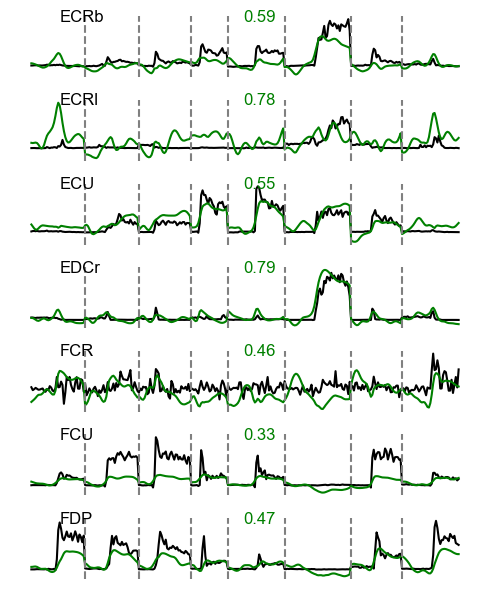

In [20]:
from utils import plot_actual_and_pred_EMG

plot_actual_and_pred_EMG('Using day-0 decoder to predict EMGs on day-k after the ADAN alignment', 
                         dayk_spike_lat_aligned, dayk_EMG_[120:], day0_decoder, bin_size, n_lags, 8, r2, dayk_EMG_names, 'green')


For each panel, the black traces are real EMGs, and the green traces are the predictions by the day-0 decoder after ADAN alignment. Comparing to a similar figure generated above, the predictions here are much closer to the real signals. Same as above, the numbers are $R^2$ values for individual muscles, and the gray dashed lines separate individual trials.